## <span style="color:green"> Laboratorio di simulazione numerica </span>
### Martina Colombo, 977556
## <span style="color:blue">  Esercitazione 9</span>

In [26]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from adjustText import adjust_text
from celluloid import Camera
from IPython.display import HTML

In [27]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

### Esercizio 09.1

#### Introduzione 


In questa esercitazione ci viene richiesto di risolvere il problema del commesso viaggiatore creando un codice basato sulla teoria degli algoritmi genetici. Dato un insieme di $N$ città ciascuna avente una determinata posizione, vogliamo trovare il tragitto che permette al commesso viaggiatore di visitare tutte le città una ed una sola volta e ritornare alla città di partenza percorrendo la minor distanza possibile. Lo scopo del problema è dunque quello di minimizzare la funzione costo della distanza tra le città.

Gli algoritmi genetici sono utilizzati per risolvere problemi di ottimizzazione basandosi su principi biologici come la selezione naturale e l'evoluzione. In un algoritmo genetico si ha una popolazione iniziale formata da una serie di cromosomi, i cromosomi sono a loro volta formati da geni e i geni possono assumere diverse forme chiamate alleli. Sulla popolazione possono essere fatte una serie di operazioni: la selezione, il crossover e le mutazioni, che determinano l'evoluzione della popolazione stessa. Il processo di evoluzione per come è costruito porta alla creazione di una nuova popolazione o generazione sempre più prestante e migliore rispetto alla precedente dal punto di vista delle capacità di sopravvivenza, adattamento e riproduzione. La funzione che misura le capacità di un individuo è chiamata fitness. La selezione è l'operazione con cui vengono scelti i cromosomi migliori per la riproduzione, più la fitness di un cromosoma è alta, maggiore è la probabilità che venga selezionato per la riproduzione. Dopo che due individui sono stati selezionati si scambiano parte del loro materiale genetico formando due figli, questo meccanismo è chiamato crossover. Le mutazioni infine consistono nella modifica della sequenza di geni all'interno di un cromosoma tramite lo scambio di due o più geni, le mutazioni evitano lo stallo della popolazione e aggiungo diversità alla popolazione stessa. 

Il problema del commesso viaggiatore si presta ad essere risolto tramite i principi degli algoritmi genetici essendo anch'esso un problema di ottimizzazione e presentando un forte parallelismo con la struttura di un algoritmo genetico. Le città che devono essere visitate possono essere viste come geni, ogni città ha un nome diverso (o allele), un cromosoma rappresenta il percorso che viene effettuato dal viaggiatore, ovvero la sequenza di città (o geni) visitate. La popolazione è l'insieme dei percorsi (o cromosomi) possibili. La fitness di un percorso è data dalla funzione distanza che deve essere minimizzata di generazione in generazione tramite le operazioni di selezione, crossover e mutazione menzionate sopra.

#### Descrizione del problema

Consideriamo $N=32$ città aventi posizioni $\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N$ e un insieme di $M=100$ percorsi iniziali $\vec{c}_1, \vec{c}_2, \dots, \vec{c}_M$. Un singolo percorso è descritto da una serie di posizioni successive $(x_i, y_i)$ e da un numero compreso tra $1$ a $32$ che rappresenta l'allele ovvero il nome della città stessa. Scegliamo come funzione distanza o fitness la norma al quadrato delle distanze $L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N)$ definita come:

$$
L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|^2.
$$

Creiamo per prima cosa un operatore di **selezione** che ordina la popolazione in base alla fitness, ovvero dal valore di $L^{(2)}$ più basso al più alto e che sceglie i percorsi o cromosomi per effettuare il crossover. La scelta deve ricadere tra i cromosomi che hanno una fitness migliore quindi è necessario determinare un metodo che ci assicura di scegliere l'indice $j$, che rappresenta uno dei genitori, nella prima metà della popolazione cioè nella fetta di candidati che hanno valore di $L^{(2)}$ minore. Dato $r$ numero casuale tra $[0,1]$ e $p$ esponente conveniente, otteniamo l'indice $j$ del genitore tramite $j=N\times int(r^p)$. Nel nostro caso scegliamo un valore di $p$ pari a $2.5$, infatti come vediamo dal seguente grafico la scelta di questo valore ci garantisce di selezionare un indice $j$ entro la prima metà della popolazione ordinata nell'$80\%$ circa dei casi.


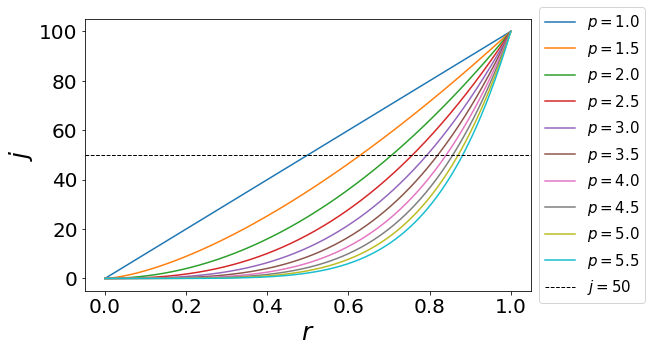

In [28]:
plt.figure(figsize=(8,5))

r=np.linspace(0,1,1000)
p=np.arange(1, 6, 0.5)
N=100

for i in p:
    plt.plot(r, N*r**i, label= f'$p={i}$')
    
plt.axhline(y=N/2, color='k', linestyle='--', label = f'$j={50}$', linewidth=1.0)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$r$', fontsize=25)
plt.ylabel('$j$', fontsize=25)   
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.show()

Implementiamo poi un operatore di **crossover** che permette lo scambio di materiale genetico tra i due genitori scelti tramite la selezione e che dà vita a due nuovi figli. L'operatore di crossover viene chiamato con una probabilità dell' $80\%$, nel caso in cui non venga chiamato i genitori vengono direttamente passati alla generazione successiva. Una volta creata la nuova generazione introduciamo gli operatori di **mutazione** che sono necessari per l'operazione di minimizzazzione, con solo l'uso del crossover infatti non è possibile trovare la distanza minima tra le città perché dopo una serie di generazioni si ha che la popolazione si arresta su cromosomi tutti uguali tra loro che sono ancora lontani dal migliore.

Introduciamo quattro tipi di mutazione:
- **Pair_Permutation**: scambio di due geni all'interno del cromosoma ad eccezione del primo gene che rimane fisso;
- **Swap_Permutation**: trasposizione di $m$ geni contigui in fondo al cromosoma (con $m<N/2$); 
- **Contiguous_Permutation**: scambio di $m$ geni contigui con altri $m$ geni contigui all'interno del cromosoma(con $m<N/2$);
- **Reverse_Permutation**: inversione dell'ordine di un range di geni all'interno del cromosoma.


Le mutazioni sono chiamate all'interno dell'algoritmo solo dopo aver creato una generazione completa tramite l'operazione di crossover, ogni mutazione è chiamata un numero di volte pari a quello del numero di individui nella popolazione che nel nostro caso è pari a $100$, le mutazioni vengono poi accettate con una probabilità $p_m<10\%$.

#### Applicazione

##### Città su circonferenza unitaria

Applichiamo ora il codice per ottimizzare un percorso effettuato su $32$ città casualmente distribuite sulla circonferenza unitaria. Ci aspettiamo che il percorso migliore non abbia incroci e che segua il più possibile il perimetro della circonferenza. 

Riportiamo di seguito il valore della funzione $L^{(2)}_{best}$ del percorso migliore in dipenza della generazione e del valor medio della funzione distanza $\langle L^{(2)} \rangle$ calcolato per ogni generazioni in dipendenza dalla generazione stessa.

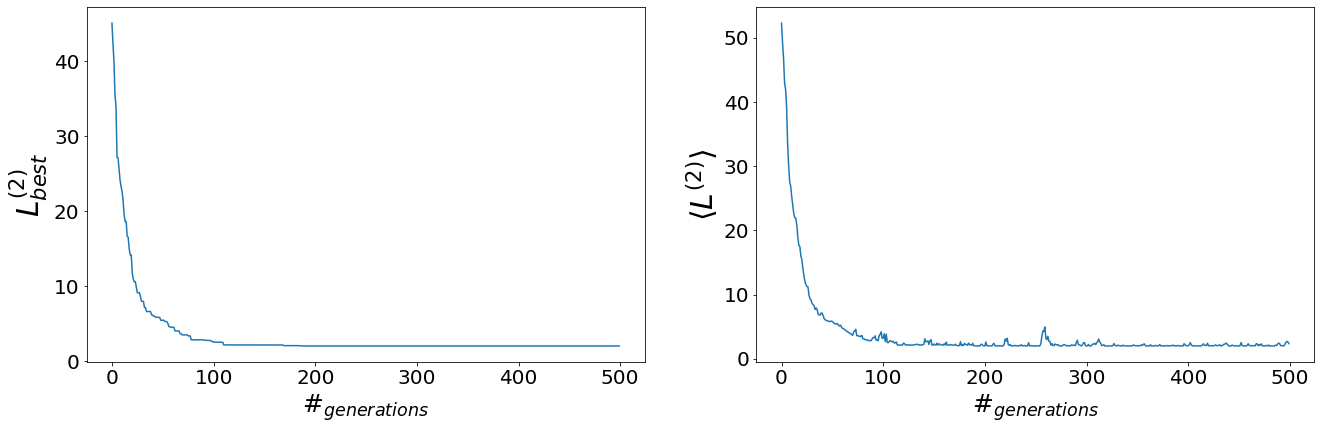

In [29]:
plt.figure(figsize=(22, 14))

generation, best_distance = np.loadtxt("Circonferenza/L2.dat", usecols=(0, 1), delimiter=' ', unpack='true')

plt.subplot(2,2,1)
plt.plot(generation, best_distance, label='$L^{(2)}$')
plt.xlabel("$\#_{generations}$", fontsize=25)
plt.ylabel('$L^{(2)}_{best}$', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
 

plt.subplot(2,2,2)

generation, best_distance = np.loadtxt("Circonferenza/<L2>.dat", usecols=(0, 1), delimiter=' ', unpack='true')

plt.plot(generation, best_distance, label='$L^{(2)}$')
plt.xlabel("$\#_{generations}$", fontsize=25)
plt.ylabel('$\langle L^{(2)} \\rangle$', fontsize=30)
plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 

plt.show()

Dai grafici vediamo un andamento descrescente della distanza in funzione del numero di generazioni, di conseguenza possiamo dire che l'algoritmo effettivamente ottimizza la funzione $L^{(2)}$. Vediamo che entro le prime $100$ generazioni otteniamo già una buona minimizzazione, il cromosoma migliore in questo caso è ottenuto entro la $200-esima$ generazione.

Riportiamo di seguito la rappresentazione di vari percorsi ottimali in funzione del numero di generazioni (mostriamo il primo percorso nella generazione $n$-esima ordinata secondo la fitness) e infine il percorso ottimale ottenuto alla fine della simulazione.

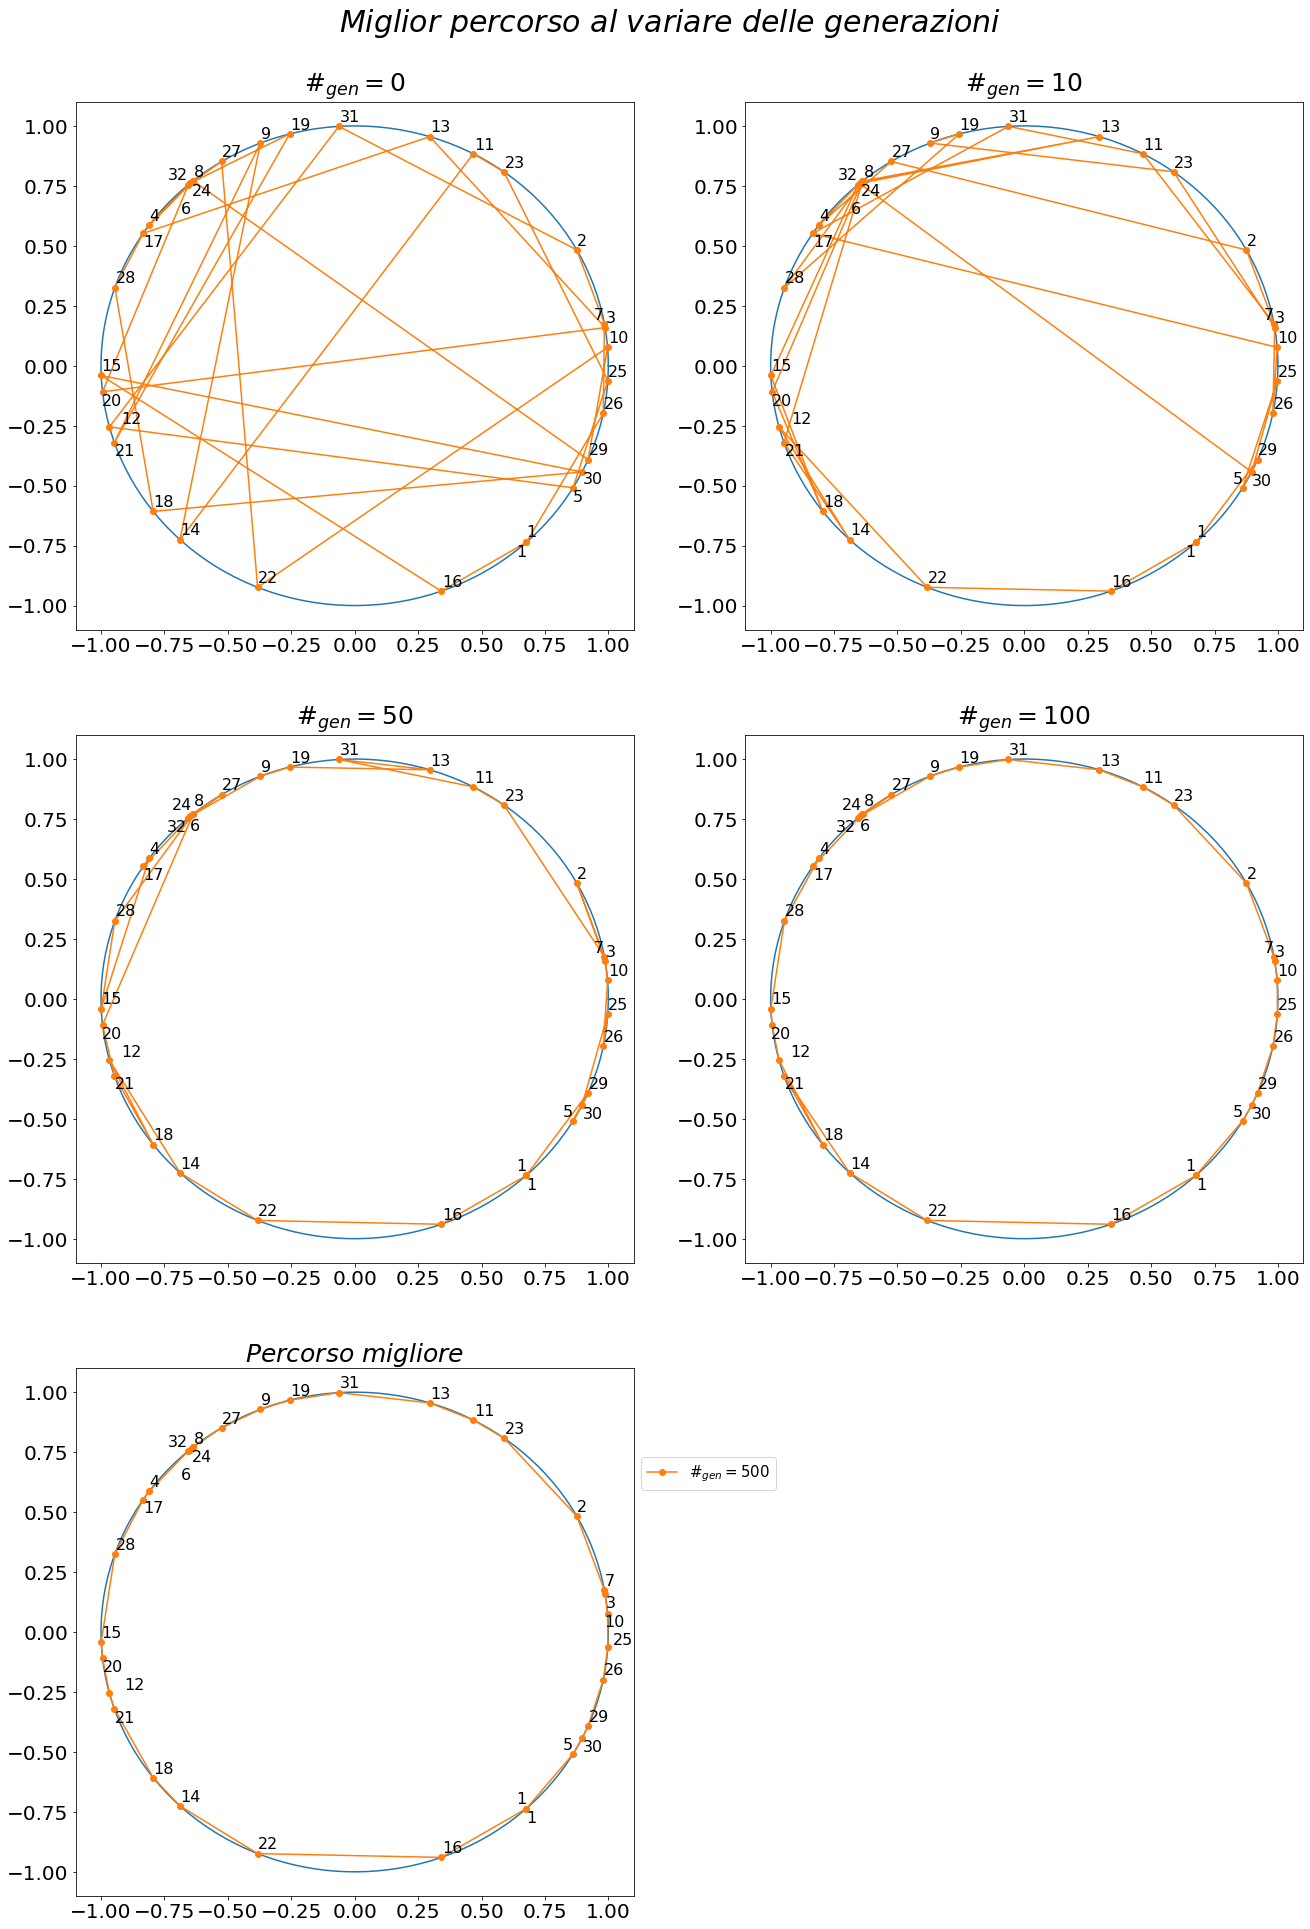

In [30]:
plt.figure(figsize=(22,33))

coord_x, coord_y = np.loadtxt("Circonferenza/Best_cromosoma_iniziale.dat", usecols=(0, 1), delimiter=' ', unpack='true', skiprows=1)
name = np.loadtxt("Circonferenza/Best_cromosoma_iniziale.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true', skiprows=1)

plt.subplot(3,2,1)
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = 1 
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 
plt.plot(x, y) 

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$\#_{gen}=0$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)


coord_x, coord_y = np.loadtxt("Circonferenza/Best_gen_10.dat", usecols=(0, 1), delimiter=' ', unpack='true')
name = np.loadtxt("Circonferenza/Best_gen_10.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true')

plt.subplot(3,2,2)

angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = 1 
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 
plt.plot(x, y) 

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$\#_{gen}=10$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)



plt.subplot(3,2,3)

coord_x, coord_y = np.loadtxt("Circonferenza/Best_gen_50.dat", usecols=(0, 1), delimiter=' ', unpack='true')
name = np.loadtxt("Circonferenza/Best_gen_50.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true')

angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = 1 
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 
plt.plot(x, y) 

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$\#_{gen}=50$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)


plt.subplot(3,2,4)

coord_x, coord_y = np.loadtxt("Circonferenza/Best_gen_100.dat", usecols=(0, 1), delimiter=' ', unpack='true')
name = np.loadtxt("Circonferenza/Best_gen_100.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true')


angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = 1 
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 
plt.plot(x, y) 

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title('$\#_{gen}=100$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)

plt.subplot(3,2,5)

coord_x, coord_y = np.loadtxt("Circonferenza/Best_cromosoma_finale.dat", usecols=(0, 1), delimiter=' ', unpack='true', skiprows=1)
name = np.loadtxt("Circonferenza/Best_cromosoma_finale.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true', skiprows=1)

angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = 1 
x = radius * np.cos( angle ) 
y = radius * np.sin( angle ) 
plt.plot(x, y) 

plt.plot(coord_x, coord_y, '-o', label='$\#_{gen}=500$')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$Percorso$ $migliore$', fontsize=25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=15)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)

plt.suptitle("$Miglior$ $percorso$ $al$ $variare$ $delle$ $generazioni$", fontsize=30, y=0.92)

plt.show()

In [31]:
first = np.loadtxt('Circonferenza/Best_cromosoma_iniziale.dat', max_rows=1, unpack='true')
last= np.loadtxt('Circonferenza/Best_cromosoma_finale.dat', max_rows=1, unpack='true')
print('Distanza iniziale:', (first)) 
print('Distanza finale:', (last)) 

Distanza iniziale: 47.705
Distanza finale: 1.99175


Come detto precedentemente il percorso migliore risulta effettivamente quello privo di incroci e che segue il più possibile l'andamento della circonferenza. 

##### Città contenute in un quadrato

Una volta verificato che l'algoritmo è funzionante e minimizza la funzione distanza tramite il modello intuitivo di città distribuite su una circonferenza, applichiamo l'algoritmo ad un altro caso, quello di città casualmente distribuite in un quadrato di lato pari a due. Riportiamo anche in questo caso i grafici della funzione distanza $L^{(2)}_{best}$ ed $\langle L^{(2)} \rangle$ in funzione del numero di generazioni. Come prima vediamo un andamento descrescente del valore della distanza in funzione del numero di generazioni. Vediamo che l'algoritmo ha una buona minimizzazione entro le prime $100$ generazioni, dopo la $200-esima$ generazione la distanza rimane circa costante.

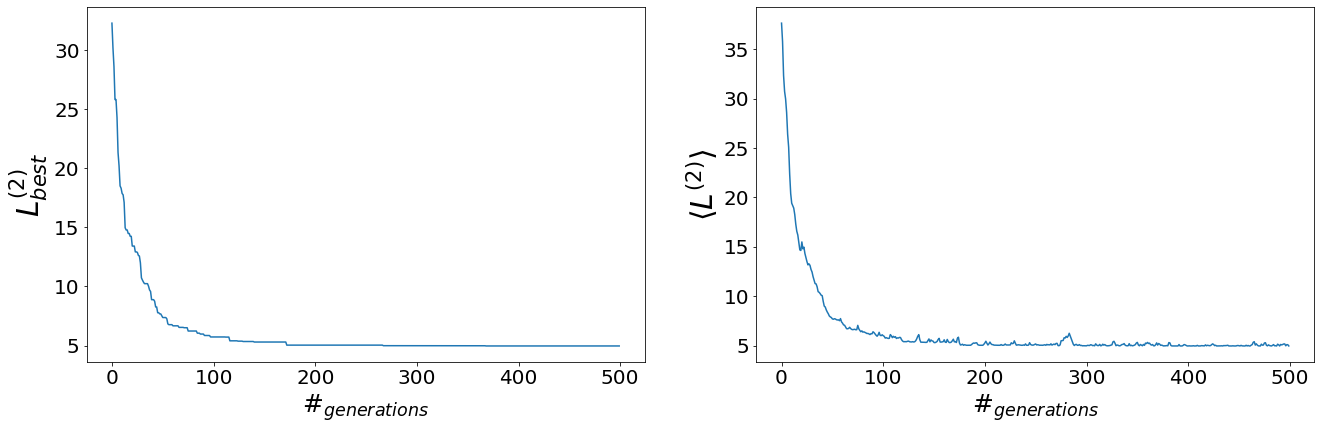

In [32]:
plt.figure(figsize=(22, 14))

generation, best_distance = np.loadtxt("Quadrato/L2.dat", usecols=(0, 1), delimiter=' ', unpack='true')

plt.subplot(2,2,1)
plt.plot(generation, best_distance, label='$L^{(2)}$')
plt.xlabel("$\#_{generations}$", fontsize=25)
plt.ylabel('$L^{(2)}_{best}$', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
 

plt.subplot(2,2,2)

generation, best_distance = np.loadtxt("Quadrato/<L2>.dat", usecols=(0, 1), delimiter=' ', unpack='true')

plt.plot(generation, best_distance, label='$L^{(2)}$')
plt.xlabel("$\#_{generations}$", fontsize=25)
plt.ylabel('$\langle L^{(2)} \\rangle$', fontsize=30)
plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 

plt.show()

Mostriamo una serie di percorsi ottimali al variare del numero di generazioni e infine mostriamo il percorso ottimale ottenuto.

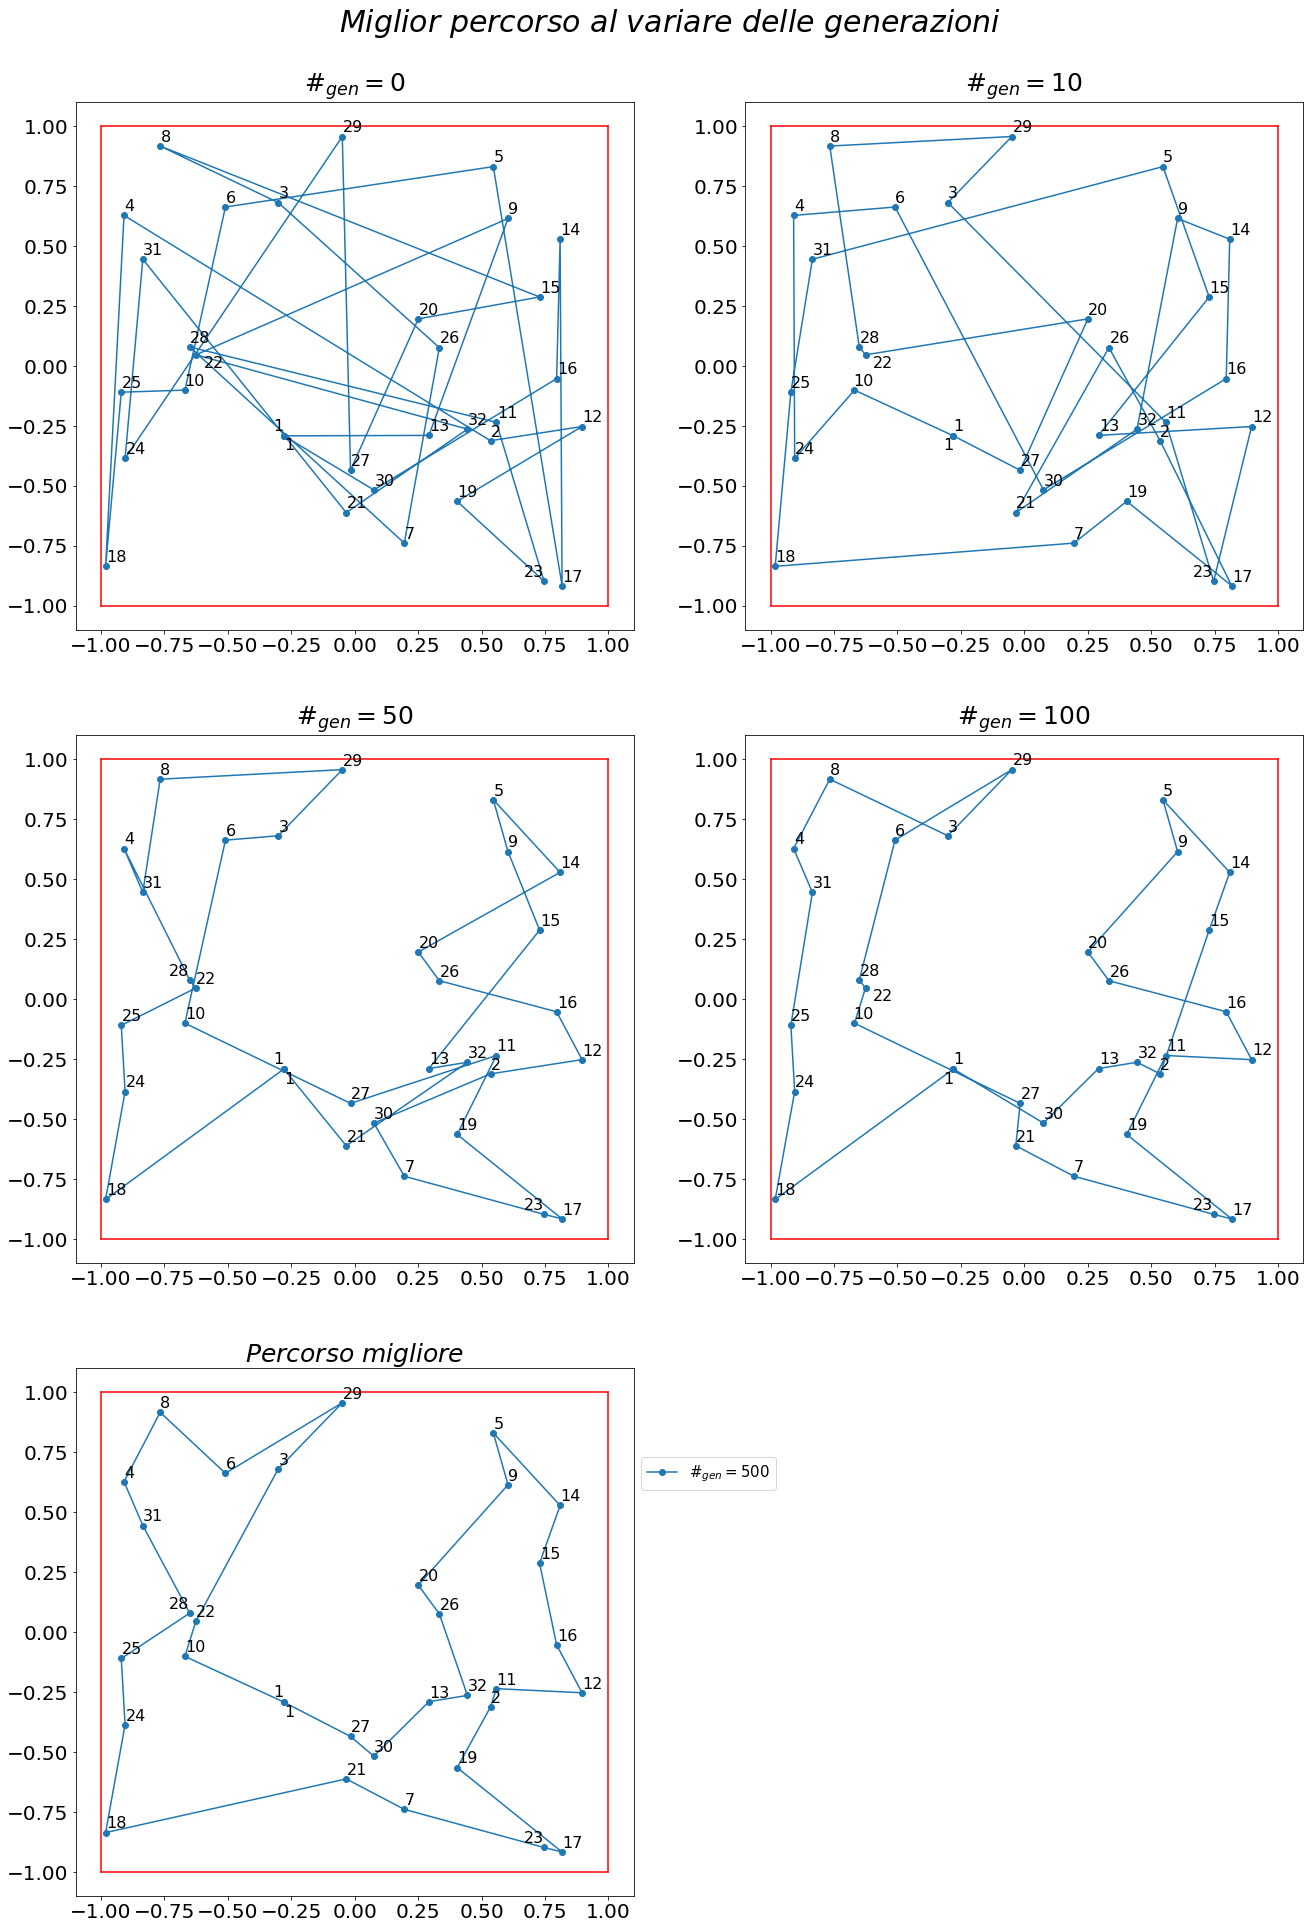

In [33]:
plt.figure(figsize=(22,33))

coord_x, coord_y = np.loadtxt("Quadrato/Best_cromosoma_iniziale.dat", usecols=(0, 1), delimiter=' ', unpack='true', skiprows=1)
name = np.loadtxt("Quadrato/Best_cromosoma_iniziale.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true', skiprows=1)

plt.subplot(3,2,1)

x=np.arange(-1., 1.1, 0.1)
y=np.ones(len(x))

plt.plot(x,y,c='red') 
plt.plot(x,-y,c='red')
plt.plot(y,x,c='red')
plt.plot(-y,x,c='red')

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$\#_{gen}=0$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)


coord_x, coord_y = np.loadtxt("Quadrato/Best_gen_10.dat", usecols=(0, 1), delimiter=' ', unpack='true')
name = np.loadtxt("Quadrato/Best_gen_10.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true')

plt.subplot(3,2,2)

x=np.arange(-1., 1.1, 0.1)
y=np.ones(len(x))


plt.plot(x,y,c='red') 
plt.plot(x,-y,c='red')
plt.plot(y,x,c='red')
plt.plot(-y,x,c='red')

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$\#_{gen}=10$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)



plt.subplot(3,2,3)

coord_x, coord_y = np.loadtxt("Quadrato/Best_gen_50.dat", usecols=(0, 1), delimiter=' ', unpack='true')
name = np.loadtxt("Quadrato/Best_gen_50.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true')

x=np.arange(-1., 1.1, 0.1)
y=np.ones(len(x))

plt.plot(x,y,c='red') 
plt.plot(x,-y,c='red')
plt.plot(y,x,c='red')
plt.plot(-y,x,c='red')

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$\#_{gen}=50$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)


plt.subplot(3,2,4)

coord_x, coord_y = np.loadtxt("Quadrato/Best_gen_100.dat", usecols=(0, 1), delimiter=' ', unpack='true')
name = np.loadtxt("Quadrato/Best_gen_100.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true')

x=np.arange(-1., 1.1, 0.1)
y=np.ones(len(x))


plt.plot(x,y,c='red') 
plt.plot(x,-y,c='red')
plt.plot(y,x,c='red')
plt.plot(-y,x,c='red')

plt.plot(coord_x, coord_y, '-o')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title('$\#_{gen}=100$', fontsize=25)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)

plt.subplot(3,2,5)

coord_x, coord_y = np.loadtxt("Quadrato/Best_cromosoma_finale.dat", usecols=(0, 1), delimiter=' ', unpack='true', skiprows=1)
name = np.loadtxt("Quadrato/Best_cromosoma_finale.dat", dtype=int, usecols=(2), delimiter=' ', unpack='true', skiprows=1)

x=np.arange(-1., 1.1, 0.1)
y=np.ones(len(x))


plt.plot(x,y,c='red') 
plt.plot(x,-y,c='red')
plt.plot(y,x,c='red')
plt.plot(-y,x,c='red')

plt.plot(coord_x, coord_y, '-o', label='$\#_{gen}=500$')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('$Percorso$ $migliore$', fontsize=25)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=15)
texts = [plt.text(coord_x[i], coord_y[i], name[i], fontsize=16) for i in range(len(coord_x))]
adjust_text(texts)

plt.suptitle("$Miglior$ $percorso$ $al$ $variare$ $delle$ $generazioni$", fontsize=30, y=0.92)

plt.show()

In [34]:
first = np.loadtxt('Quadrato/Best_cromosoma_iniziale.dat', max_rows=1, unpack='true')
last= np.loadtxt('Quadrato/Best_cromosoma_finale.dat', max_rows=1, unpack='true')
print('Distanza iniziale:', (first)) 
print('Distanza finale:', (last)) 

Distanza iniziale: 34.7134
Distanza finale: 4.96647
